<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 멋진 작사가 만들기

# 1 개요

## 1-1. 목표
- 입력 한 단어로, 문장을 만드는 LSTM이용한 NN을 구현한다.
- loss 2.2 이하

## 1-2. 방법
- NN구성: Embedding 레이어 1개, LSTM 레이어 2개, Dense 레이어 1개 순
- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 tensor로 변환
- tf.data.Dataset.from_tensor_slices()를 이용해 tensor를 tf.data.Dataset객체로 변환
- 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수 있기에, corpus기준으로 token수를 15로 제한
- 하이퍼파라미터를 tuning한다.

## 1-3. 사전 준비

### ■ 기본 라이브러리 load하기

In [2]:
# import warnings
# warnings.filterwarnings("ignore")
# import pandas as pd
import numpy as np
import os, re
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

### ■ 기본 code load하기

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) #  4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    return sentence

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,               # 7000단어를 기억할 수 있는 tokenizer
        filters=' ',                  # 앞에서 preprocess하므로, 여기서는 불필요
        oov_token="<unk>"             # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)  
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence를 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated  

# 2 데이터 준비

## 2-1. raw corpus 파일 download하기

In [4]:
!rm -r /content/lyrics
!mkdir -p /content/lyrics
!wget -O /content/lyrics.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/lyrics/lyrics.zip
!unzip /content/lyrics.zip -d /content/lyrics
!rm /content/lyrics.zip

--2022-05-19 15:48:10--  https://raw.githubusercontent.com/twelvesense/first-repository/master/data/lyrics/lyrics.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2004593 (1.9M) [application/zip]
Saving to: ‘/content/lyrics.zip’

/content/lyrics.zip 100%[===================>]   1.91M  --.-KB/s    in 0.06s   

2022-05-19 15:48:10 (32.3 MB/s) - ‘/content/lyrics.zip’ saved [2004593/2004593]

Archive:  /content/lyrics.zip
  inflating: /content/lyrics/adele.txt  
  inflating: /content/lyrics/al-green.txt  
  inflating: /content/lyrics/alicia-keys.txt  
  inflating: /content/lyrics/amy-winehouse.txt  
  inflating: /content/lyrics/beatles.txt  
  inflating: /content/lyrics/bieber.txt  
  inflating: /content/lyrics/bjork.txt  
  inflating: /content/lyrics/blink-1

In [5]:
txt_file_path = '/content/lyrics/*'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

## 2-2. corpus 파일 분석하기

In [6]:
print("데이터 크기:", len(raw_corpus))
print("Examples:")
raw_corpus[:10]

데이터 크기: 187088
Examples:


['They say get ready for the revolution',
 "I think it's time we find some sorta solution",
 "Somebody's caught up in the endless pollution",
 'They need to wake up, stop living illusions I know you need to hear this',
 "Why won't somebody feel this",
 'This is my wish that we all feel connected',
 'This is my wish that nobodies neglected Be like a rocket baby',
 'Be like a rocket Take off',
 'Just fly, away (ay, ay)',
 'To find your space Take off']

## 2-4. 데이터 전처리하기

### ■ corpus 생성 시, sentence별 token수를 최대 15개로 제한하기

In [7]:
MAX_LEN = 15                                  # sentence별 최대 token수
num_removed = 0                               # token수가 15초과하는 sentence의 수
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue            # 문장길이 0
    if sentence[-1] == ":": continue           # 문장끝 :
    
    preprocessed_sentence = preprocess_sentence(sentence)
    # 15개 까지만...
    if (preprocessed_sentence[:preprocessed_sentence.find('<end>')].count(' ') + 1) > MAX_LEN: 
        num_removed += 1
        continue
    corpus.append(preprocessed_sentence)

In [8]:
num_removed                                     # token수가 15초과하여 corpus에 제외된 sentence의 수

19736

In [9]:
print("데이터 크기:", len(corpus))
print("Examples:")
corpus[:10]

데이터 크기: 156013
Examples:


['<start> they say get ready for the revolution <end>',
 '<start> i think it s time we find some sorta solution <end>',
 '<start> somebody s caught up in the endless pollution <end>',
 '<start> why won t somebody feel this <end>',
 '<start> this is my wish that we all feel connected <end>',
 '<start> this is my wish that nobodies neglected be like a rocket baby <end>',
 '<start> be like a rocket take off <end>',
 '<start> just fly , away ay , ay <end>',
 '<start> to find your space take off <end>',
 '<start> just fly , away ay , ay <end>']

## 2-5. tensor 생성하기

In [10]:
tensor, tokenizer = tokenize(corpus)

[[   2   38   71 ...    0    0    0]
 [   2    4  130 ...    0    0    0]
 [   2  246   17 ...    0    0    0]
 ...
 [   2   20  149 ...    0    0    0]
 [   2    4   35 ...    3    0    0]
 [   2 1061   10 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fdb14743b10>


## 2-6. tensor 분석하기

In [11]:
len(tensor)

156013

In [12]:
tensor[0:10,:]

array([[   2,   38,   71,   43,  294,   28,    6, 3273,    3,    0,    0,
           0,    0,    0,    0],
       [   2,    4,  130,   11,   17,   76,   21,  207,   94, 3521, 6826,
           3,    0,    0,    0],
       [   2,  246,   17,  622,   29,   14,    6, 3069,    1,    3,    0,
           0,    0,    0,    0],
       [   2,  119,  178,   16,  246,  106,   41,    3,    0,    0,    0,
           0,    0,    0,    0],
       [   2,   41,   26,   13,  275,   15,   21,   25,  106, 5061,    3,
           0,    0,    0,    0],
       [   2,   41,   26,   13,  275,   15,    1,    1,   27,   23,    9,
        2967,   52,    3,    0],
       [   2,   27,   23,    9, 2967,   83,  117,    3,    0,    0,    0,
           0,    0,    0,    0],
       [   2,   32,  254,    5,  138,  610,    5,  610,    3,    0,    0,
           0,    0,    0,    0],
       [   2,   10,  207,   19,  689,   83,  117,    3,    0,    0,    0,
           0,    0,    0,    0],
       [   2,   32,  254,    5,  138,

## 2-7. source 문장, target 문장 만들기

In [13]:
# tensor에서 마지막 token을 잘라내서 source 문장을 생성
# 마지막 token은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]
# tensor에서 <start>를 잘라내서 target 문장을 생성합니다.
tgt_input = tensor[:, 1:]

In [14]:
print(src_input[0])
print(tgt_input[0])

[   2   38   71   43  294   28    6 3273    3    0    0    0    0    0]
[  38   71   43  294   28    6 3273    3    0    0    0    0    0    0]


## 2-8. validataion test용으로 dataset 나누기

In [15]:
# validataion test용으로 8:2로 나누기
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=22)

# 3 모델 설계

## 3-1. Model Subclassing 방식으로 구현

### ■ 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성하기

In [16]:
embedding_size = 14
hidden_size = 1024
VOCAB_SIZE = tokenizer.num_words + 1         # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

## 3-2. 기타 하이퍼파라미터 설정하기

In [17]:
epochs = 5
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
model.compile(loss=loss, optimizer=optimizer)

### ■ model에 일부 데이터를 태워 input shape 확인하기

In [19]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-3.05581052e-05, -1.01678001e-04, -2.76625051e-05, ...,
         -2.37722816e-06, -6.35645774e-05,  6.85178893e-05],
        [-1.19763106e-04, -7.99276895e-05, -5.94757585e-05, ...,
         -4.00447170e-05, -6.30353825e-05,  7.44961944e-05],
        [-1.34122209e-04, -3.04518398e-05, -4.47010498e-05, ...,
         -2.94994534e-05, -3.60709164e-05,  5.83175060e-05],
        ...,
        [ 3.04233617e-05,  1.14800270e-04,  1.73843699e-04, ...,
         -7.81622948e-05,  3.59097176e-05,  2.97314371e-04],
        [ 3.57958234e-05,  4.69887673e-05,  2.42151495e-04, ...,
         -6.97787182e-05,  1.90301434e-05,  3.15860467e-04],
        [ 1.04432780e-04,  5.60759436e-05,  3.20733758e-04, ...,
         -7.91610801e-05,  8.75983460e-05,  3.24723718e-04]],

       [[-3.05581052e-05, -1.01678001e-04, -2.76625051e-05, ...,
         -2.37722816e-06, -6.35645774e-05,  6.85178893e-05],
        [-5.73325997e-05, -1.40940319e-04, -3.

- 출력 tensor shape은 (256, 14, 7001)임
- 7001에는 token별 확률 표현
- 14는 입력 sequence와 동일한 길이의 출력 sequence를 나타냄
- 256은 이전 스텝에서 지정한 배치 사이즈

## 3-3. 모델 summary

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  98014     
                                                                 
 lstm (LSTM)                 multiple                  4255744   
                                                                 
 lstm_1 (LSTM)               multiple                  8392704   
                                                                 
 dense (Dense)               multiple                  7176025   
                                                                 
Total params: 19,922,487
Trainable params: 19,922,487
Non-trainable params: 0
_________________________________________________________________


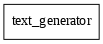

In [20]:
model.summary()
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=True,
    dpi = 70)

# 4 모델 학습

In [21]:
history = []

history = model.fit(enc_train, dec_train, 
          epochs=epochs,                         # 10
          batch_size=BATCH_SIZE,                 # 256
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/5
488/488 [==============================] - 4795s 10s/step - loss: 3.5072 - val_loss: 3.1574
Epoch 2/5
488/488 [==============================] - 5389s 11s/step - loss: 3.0552 - val_loss: 2.9825
Epoch 3/5
488/488 [==============================] - 5523s 11s/step - loss: 2.9072 - val_loss: 2.8819
Epoch 4/5
488/488 [==============================] - 5016s 10s/step - loss: 2.8092 - val_loss: 2.8163
Epoch 5/5
488/488 [==============================] - 5377s 11s/step - loss: 2.7304 - val_loss: 2.7706


# 5 모델 평가

- generate_text 함수는 시작 단어(들)을 받은 모델이 작문하게 하며, 평가는 우선 주관적 평가를 할 수 있다.
- 다음의 3가지 예에 대해서, corpus를 통한 단어의 발생확률을 잘 반영한 듯 하다.
- 의미적으로는 조금 어색한 부분도 있지만, 문법적으로 잘 작성되었다.
- 시간상 제약이 따르지만, 개선을 위해서, 보다 많은 word 수, 모델의 파라미터나 layer를 추가할 필요가 있다.

In [22]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love you to get my mind <end> '

In [36]:
generate_text(model, tokenizer, init_sentence="<start> you love")

'<start> you love me , <end> '

In [35]:
generate_text(model, tokenizer, init_sentence="<start> he likes")

'<start> he likes me , i m <unk> <end> '

- loss곡선을 보면, epoch 3에서 cross되고, 이는 overfitting의 결과로 보인다.

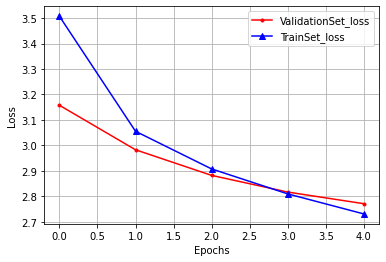

In [44]:
y_vloss = history.history['val_loss']    # validation dataset의 loss
y_loss = history.history['loss']         # train dataset의 loss

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='ValidationSet_loss')
plt.plot(x_len, y_loss, marker='^', c="blue", label='TrainSet_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# 6 회고

- 간단한 LSTM으로도 적어도 문법적으로는 그럴싸 한 결과를 얻을 수 있었다.
- 다만, loss개선을 위해서, 보다 깊은 NN을 설계할 필요성을 느꼈다.
- 충분한 validation시험이 필요했었고, epoch수도 늘리고, 다양한 하이퍼파라미터 조정도 필요했었다.
- overfit방지를 위한 drop out 등 고려해야할 것이 많았지만, 시간상 제약으로 실천하기에 어려움이 있었다.